# Categorical Boost
#### cv score :  0.5623062381852553 (5 folds)

In [33]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
import sklearn
from Functions import prepro
import warnings

import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
warnings.filterwarnings('ignore')
from catboost import Pool, CatBoostClassifier, CatBoost
import seaborn as sns


random.seed(0)

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)
%matplotlib inline

In [2]:
train_df = pd.read_csv("../../data/Processed/train2.csv")
test_df = pd.read_csv("../../data/Processed/test2.csv")
print(train_df.shape)
print(test_df.shape)

(66125, 304)
(28340, 303)


In [3]:
y = train_df["y"].values
train_df = train_df.drop("y", axis=1)

In [4]:
# add disconnection info

train_df = prepro.add_disconnection(train_df)
test_df = prepro.add_disconnection(test_df)

In [5]:
# add info about numeric column
# 武器データの中のnum_colsを持つ特徴について、チーム内の統計量を計算、levelは結構効いてる

num_cols = [
    "level", "range-main", "range-bullet-main", "range-draw-main", "direct_range-sub", "distant-range_sub", 
    "rapid", "atack", "ink-sub", "fav-main", "good-special", "DPS", "kill_time_human-main", "kill_time_ika-main",
    "front_gap_human-main", "front_gap_ika-main", "rensya_frame-main", "saidai_damege-main", "damage_min-sub", 
    "damage_max-sub", "install_num-sub", "good-sub", "direct_range-sub", "distant-range_sub", "damage_max-special", 
    "damage_min-special", "duration-special", "good-special", "direct_rad-special", "close_rad-special", "distant_rad-special"
]

#train_df = prepro.flat(train_df, num_cols)
#test_df = prepro.flat(test_df, num_cols)

train_df = prepro.add_numeric_info(train_df, num_cols)
test_df = prepro.add_numeric_info(test_df, num_cols)

# 欠損値埋め先にやろう
欠損値がある列

rank, weapon, level ⇨　回線切れ or ナワバリ

weaponの欠損に並んでそれに関係ある列、A3, A4, B3, B4 ⇨ 回線切れ

level, weaponが消えていたら回線切れ

In [6]:
# rankの欠損値を埋める
train_df, test_df = prepro.fillna_rank(train_df, test_df)

#そのほかの欠損値を埋める
train_df, test_df = prepro.fillna(train_df, test_df)

In [7]:
print(train_df.isnull().sum().sum())
print(test_df.isnull().sum().sum())

0
0


# 特徴量エンジニアリング

In [8]:
# count reskin, by mode
print("reskin")
train_df, test_df = prepro.count_reskin(train_df, test_df)
train_df, test_df = prepro.count_reskin_by_mode(train_df, test_df)

# count mainweapon, by mode
print("mainweapon")
train_df, test_df = prepro.count_mainweapon(train_df, test_df)
train_df, test_df = prepro.count_mainweapon_by_mode(train_df, test_df)

# count subweapon, by mode
print("subweapon")
train_df, test_df = prepro.count_subweapon(train_df, test_df)
train_df, test_df = prepro.count_subweapon_by_mode(train_df, test_df)

# count special, by mode
print("special")
train_df, test_df = prepro.count_special(train_df, test_df)
train_df, test_df = prepro.count_special_by_mode(train_df, test_df)

# level inverse
#train_df, test_df = prepro.level_inverse(train_df, test_df)
#train_df = prepro.add_numeric_info(train_df, ["level-inverse"])
#test_df = prepro.add_numeric_info(test_df, ["level-inverse"])

#identify A1
train_df, test_df = prepro.identify_A1(train_df, test_df)


# 水増し, A1も統計量に含めた特徴を作る場合は水ましより先にやる
print("mizumashi")
train_df, y = prepro.mizumashi(train_df, y)

# is_nawabari
train_df, test_df = prepro.is_nawabari(train_df, test_df)

# match rank
train_df, test_df = prepro.match_rank(train_df, test_df)


reskin
mainweapon
subweapon
special
mizumashi


In [9]:
# add team info

train_df,  test_df = prepro.addTeamInfo(train_df, test_df, cols=["special", "subweapon", "category1", "category2", "mainweapon"])

(160590, 708)
special-A
special-B
subweapon-A
subweapon-B
category1-A
category1-B
category2-A
category2-B
mainweapon-A
mainweapon-B
(160590, 902)
complete


In [10]:
# categorize team

categorize_col = ["category1", "category2", "subweapon", "special", "mainweapon"]
for col in categorize_col:
    print(col)
    train_df_, test_df_ = prepro.categorize_team(train_df, test_df, col)

category1
category2
subweapon
special
mainweapon


In [11]:
# product categorical feature
train_df, test_df = prepro.prod(train_df, test_df, "mode", "stage")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-category1-A")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-category1-B")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-category2-A")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-category2-B")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-mainweapon-A")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-mainweapon-B")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-subweapon-A")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-subweapon-B")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-special-A")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-special-B")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "match_rank")

train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-category1-A")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-category1-B")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-category2-A")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-category2-B")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-mainweapon-A")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-mainweapon-B")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-subweapon-A")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-subweapon-B")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-special-A")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-special-B")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "match_rank")


train_df, test_df = prepro.prod(train_df, test_df, "mode", "reskin-A1")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "reskin-A2")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "reskin-A3")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "reskin-A4")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "reskin-B1")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "reskin-B2")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "reskin-B3")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "reskin-B4")

In [12]:
# make input

drop_cols = ["id", "lobby", "lobby-mode",  "period", "game-ver", "A1-weapon", "A2-weapon", "A3-weapon", "A4-weapon", \
              "B1-weapon", "B2-weapon", "B3-weapon", "B4-weapon"]

X, test_X = prepro.make_input(train_df, test_df, drop_cols, categorical_encode=False, scaler=False, verbose=False)

categorical_features_indices = np.where(X.dtypes == "object")[0]

complete


# 学習

In [13]:
# 全データを5つに分割
random.seed(random.randint(0, 10000))
SIZE = X.shape[0]
K = 5
cat_tgtenc_cols = ["mode", "stage", "team-category1-A", "team-category1-B"]
#cat_tgtenc_cols = ["mode", "stage"]

#folds = prepro.make_kfolds(SIZE, K)
#folds = prepro.make_stratified_kfolds(X, y, K)
folds = prepro.make_stratified_kfolds(X, X["mode"] + y.astype(str), K, shuffle=True)

print(len(folds))
for i, fold in enumerate(folds):
    print("fold ", i+1, " size is ", len(fold))
    
    
if SIZE != len(set(sum(folds, []))):
    print("error is occuring in spliting")
else :
    print("successfully split")
    
params = {
    "loss_function" : "Logloss",
    "eval_metric" : "Logloss",
    "iterations":2000,
    "learning_rate" : 0.05,
    "use_best_model": True,
    "random_seed":1,

    

}

THRESHOLD = 0.50
models = []
cv_scores = []
temp = 0
train_pred = []
valid_ys = []

all_indices = sum(folds, [])
for i in range(K):
    print("======================== fold {} ========================".format(i+1))
    valid_indices = folds[i]
    train_indices = list(set(all_indices) - set(valid_indices))
    # print("train ", len(train_indices), " , valid ", len(valid_indices))
    

    train_X = X.iloc[train_indices]
    try:
        train_y = y.iloc[train_indices]
    except:
        train_y = y[train_indices]
    valid_X = X.iloc[valid_indices]
    try:
        valid_y = y.iloc[valid_indices]
    except:
        valid_y = y[valid_indices]
    
    
    
    
    train_data = Pool(train_X, train_y, cat_features=categorical_features_indices)
    valid_data = Pool(valid_X, valid_y, cat_features=categorical_features_indices)
    
    model = CatBoostClassifier(**params)

    
    model.fit(
        train_data,
        eval_set=valid_data,
        early_stopping_rounds=10,
        verbose=100,
        use_best_model=True,
    )
    
    pred = model.predict(valid_X)
    # pred = np.where(pred < THRESHOLD, 0, 1)
    train_pred.append(pred)
    temp += np.sum(pred) 
    
    score = accuracy_score(pred, valid_y)
    
    models.append(model)
    cv_scores.append(score)
    
    
print("cv score : ", np.mean(cv_scores))    
print("cv ratio : ", temp / SIZE)

5
fold  1  size is  26450
fold  2  size is  26450
fold  3  size is  26450
fold  4  size is  26450
fold  5  size is  26450
successfully split
0:	learn: 0.6927337	test: 0.6927945	best: 0.6927945 (0)	total: 957ms	remaining: 31m 53s
100:	learn: 0.6804593	test: 0.6841097	best: 0.6841097 (100)	total: 1m 46s	remaining: 33m 17s
200:	learn: 0.6747468	test: 0.6812254	best: 0.6812254 (200)	total: 3m 44s	remaining: 33m 31s
300:	learn: 0.6687935	test: 0.6794943	best: 0.6794899 (299)	total: 5m 35s	remaining: 31m 34s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.678823493
bestIteration = 325

Shrink model to first 326 iterations.
0:	learn: 0.6926904	test: 0.6926937	best: 0.6926937 (0)	total: 1.66s	remaining: 55m 22s
100:	learn: 0.6813680	test: 0.6841246	best: 0.6841246 (100)	total: 1m 40s	remaining: 31m 34s
200:	learn: 0.6756788	test: 0.6814713	best: 0.6814659 (199)	total: 3m 13s	remaining: 28m 52s
300:	learn: 0.6696020	test: 0.6795222	best: 0.6795222 (300)	total: 4m 46s	remaini

0.5114303122534031
0.5131847212715086
0.512718558035025
0.5138403840226569
0.5111453137040601
0.5124638578573307


array([[<AxesSubplot:title={'center':'pred'}>]], dtype=object)

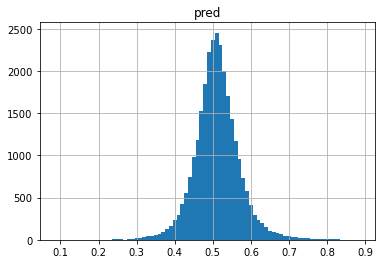

In [21]:
preds = []
for i in range(K):
    model = models[i]
    pred = model.predict(test_X, prediction_type='Probability')[:,1]
    preds.append(pred)
    print(np.sum(pred) / pred.shape[0])
    
preds = np.array(preds)
preds = np.mean(preds, axis=0)
print(np.sum(preds) / preds.shape[0])


temp = pd.DataFrame({"pred":pred})
temp.hist(bins=80)

In [15]:
preds = np.where(preds < THRESHOLD, 0, 1)
print(np.sum(preds) / preds.shape[0])

submit_df = pd.DataFrame({'y': preds})
submit_df.index.name = 'id'
submit_df.to_csv('../Submissions/submission_cat_4_{}.csv'.format(K))

0.5898376852505293


# モデル解釈

In [42]:
importance = pd.DataFrame(models[0].get_feature_importance(), index=X.columns, columns=['importance']).sort_values('importance', ascending=False)
display(importance[:120])

,importance
A-level-median,3.646351
B-level-median,3.019225
stage x team-mainweapon-B,2.972010
mode x team-special-A,2.541217
B-level-mean,1.945624
A-level-max,1.944048
B-level-sum,1.916081
B-level-max,1.701340
A-level-mean,1.698159
A-charger-category1-onehot,1.527167


In [53]:
indices = [index for index in importance.index if "team-mainweapon-A" in index]
importance.loc[indices]

,importance
team-mainweapon-A,0.0
stage x team-mainweapon-A,0.0
mode x team-mainweapon-A,0.0


In [ ]:
model[0]

In [ ]:
train_df["pred"] = 0
train_df["y"] = y.values
for i in range(K):
    train_df["pred"].iloc[folds[i]] = train_pred[i]

In [ ]:
result_df = train_df[train_df["y"] != train_df["pred"]]

In [ ]:
print(result_df[result_df["mode"] == "nawabari"].shape[0]/result_df.shape[0])
print(result_df[result_df["mode"] == "hoko"].shape[0]/result_df.shape[0])
print(result_df[result_df["mode"] == "asari"].shape[0]/result_df.shape[0])
print(result_df[result_df["mode"] == "area"].shape[0]/result_df.shape[0])
print(result_df[result_df["mode"] == "yagura"].shape[0]/result_df.shape[0])

In [ ]:
result_df[result_df["mode"] == "nawabari"]

In [20]:
preds

array([0.4339916 , 0.47415763, 0.50825852, ..., 0.54576242, 0.5183968 ,
       0.44101851])

In [49]:
def plot_feature_importance(importance,names,model_type, MAXSIZE=120):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)[:MAXSIZE]
    feature_names = np.array(names)[:MAXSIZE]

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(20,16))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

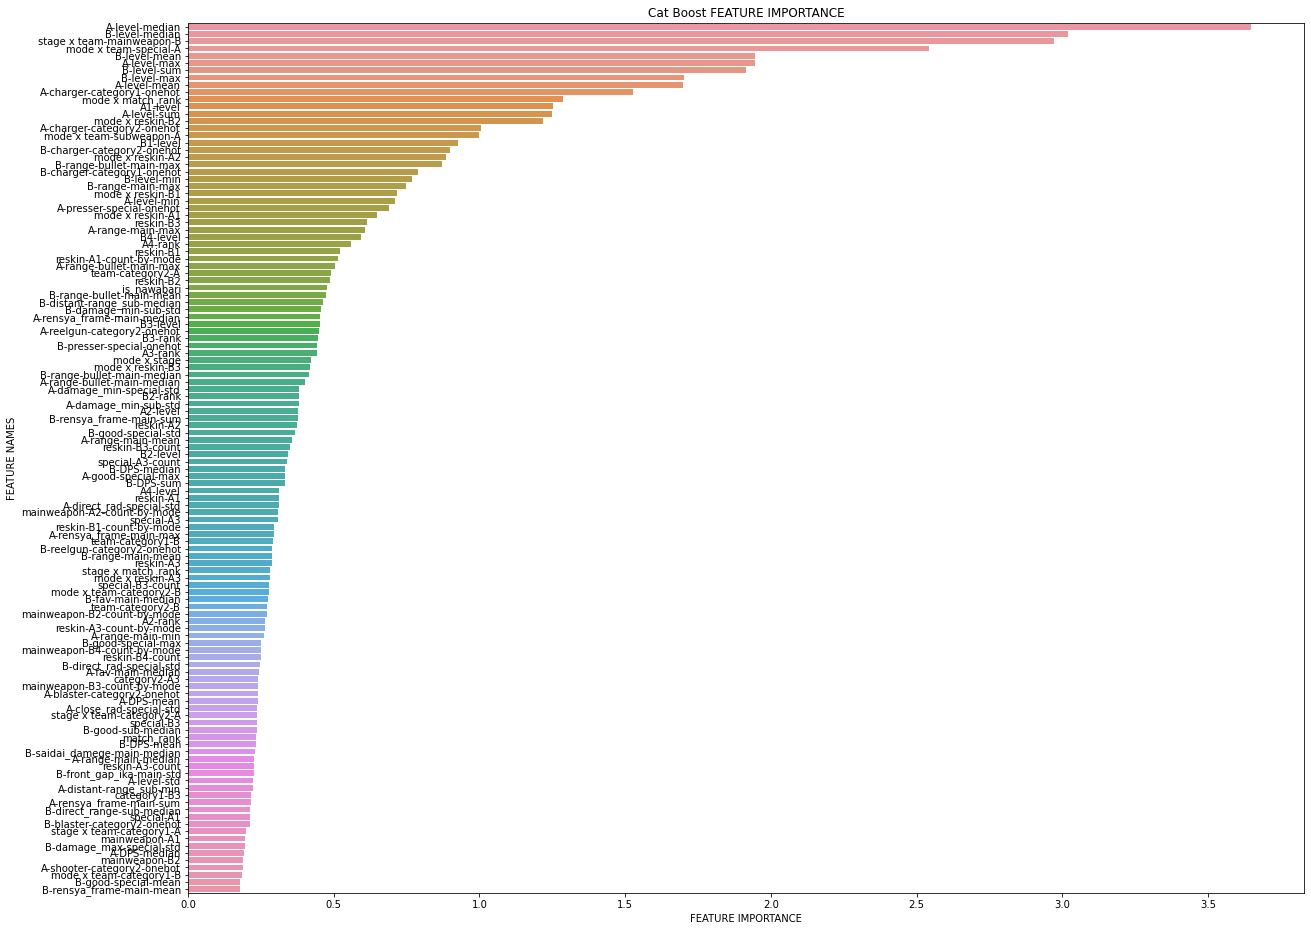

In [50]:
plot_feature_importance(importance.values.reshape(-1,), importance.index, "Cat Boost ")